In [60]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import os
import time

from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from sklearn.cluster import MeanShift
from skimage.color import label2rgb
from skimage import (
    color, feature, filters, measure, morphology, segmentation, util
)

from PIL import Image

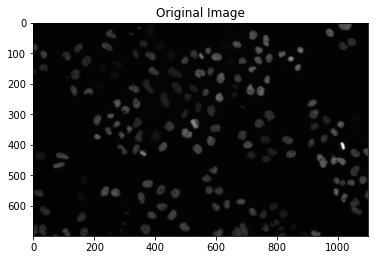

In [67]:
image = cv2.imread('t210.tif', -1)
plt.imshow(image, 'gray')
plt.title('Original Image')
plt.show()

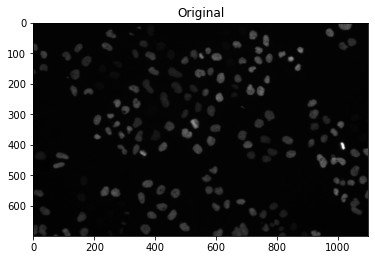

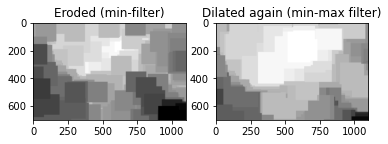

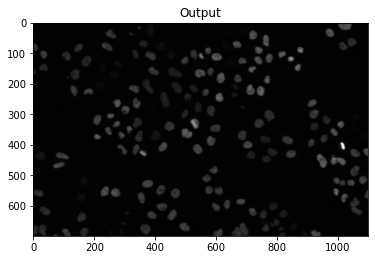

[[ 29  29  30 ...  34  38  33]
 [ 28  40  32 ...  19  34  57]
 [ 32  29  38 ...  34  35  29]
 ...
 [546 527 520 ...  29  24  27]
 [602 592 524 ...  24  31  34]
 [554 550 435 ...  25  36  28]]


In [68]:

# Testing min-max filter to remove background
img_test = image.copy()
plt.imshow(image, 'gray'), plt.title('Original')
plt.show()

kernel = np.ones((50,50),np.uint16)
img_erosion = cv2.erode(img_test, kernel, iterations=3)
img_dilated = cv2.dilate(img_erosion, kernel, iterations=3)

plt.subplot(1,2,1),plt.imshow(img_erosion, 'gray'), plt.title('Eroded (min-filter)')
plt.subplot(1,2,2),plt.imshow(img_dilated, 'gray'), plt.title('Dilated again (min-max filter)')
plt.show()

img_output = img_test.copy()

for i in range(len(img_test)):
    for j in range(len(img_test[0])):
        i_pixel = int(img_test[i][j])
        b_pixel = int(img_dilated[i][j])
        if b_pixel >= i_pixel:
            img_output[i][j] = 0
        else:
            img_output[i][j] = i_pixel - b_pixel

plt.imshow(img_output, 'gray'), plt.title('Output')
plt.show()
print(img_output)

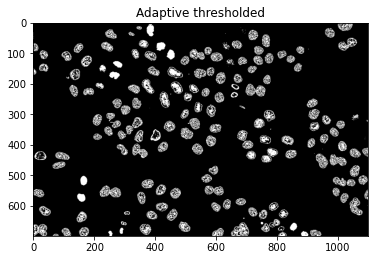

In [69]:
# Project.py

img_test = img_output.astype('uint8')

_, img_th = cv2.threshold(img_test, 240, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
plt.imshow(img_th, 'gray'), plt.title('Adaptive thresholded')
plt.show()

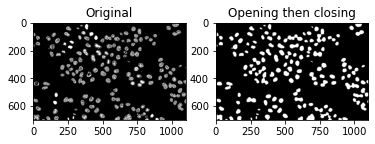

In [70]:
# Open then close operation
img_test = img_th.copy()

kernel = np.ones((5,5),np.uint16)
img1 = cv2.dilate(img_test, kernel, iterations=1)
img2 = cv2.erode(img1, kernel, iterations=1)
img3 = cv2.dilate(img2, kernel, iterations=2)
img4 = cv2.erode(img3, kernel, iterations=2)
kernel = np.ones((3,3),np.uint16)
img5 = cv2.erode(img4, kernel, iterations=1)
img6 = cv2.dilate(img5, kernel, iterations=1)

plt.subplot(1,2,1),plt.imshow(img_test, 'gray'), plt.title('Original')
plt.subplot(1,2,2),plt.imshow(img6, 'gray'), plt.title('Opening then closing')
plt.show()

In [71]:
img_output = img6.copy()

In [72]:
# Watershed implementation
img_test = img_output.copy()
distance = ndi.distance_transform_edt(img_test)

In [73]:
coords = peak_local_max(distance, min_distance=7)
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers = ndi.label(mask)[0]

In [74]:
segmented_cells = watershed(-distance, markers, mask=img_test)

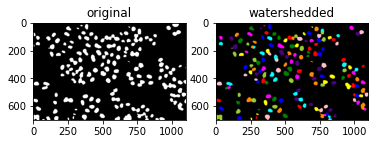

In [75]:
plt.subplot(1,2,1),plt.imshow(img_test, 'gray'), plt.title('original')
plt.subplot(1,2,2),plt.imshow(label2rgb(segmented_cells, bg_label=0)), plt.title('watershedded')
plt.show()

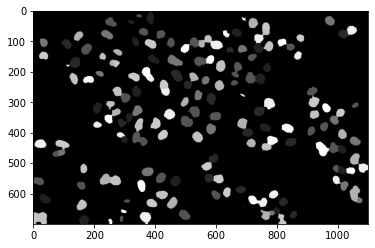

In [76]:
img_seg = label2rgb(segmented_cells, bg_label=0)

for i in range(len(img_seg)):
    for j in range(len(img_seg[0])):
        img_seg[i][j][0] = int(img_seg[i][j][0]*255)
        img_seg[i][j][1] = int(img_seg[i][j][1]*255)
        img_seg[i][j][2] = int(img_seg[i][j][2]*255)
        

img_seg = img_seg.astype('uint8')
img_seg = cv2.cvtColor(img_seg, cv2.COLOR_RGB2GRAY)

plt.imshow(img_seg, 'gray')
plt.show()

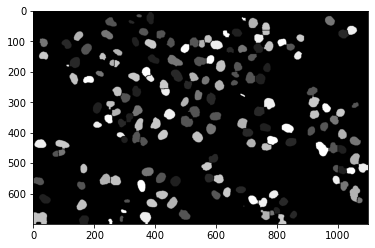

In [77]:
new_img_seg = img_seg.copy()
for i in range(len(img_seg)):
    for j in range(len(img_seg[0])):
        pixel = img_seg[i][j]
        if (pixel != 0):
            found = False
            for a in range(-1, 2):
                for b in range(-1,2):
                    if i+a >= 0 and i+a < len(img_seg) and j+b >= 0 and j+b < len(img_seg[0]):
                        if img_seg[i+a][j+b] != 0 and img_seg[i+a][j+b] != pixel:
                            found = True
                            break
                if (found):
                    break
            if (found):
                new_img_seg[i][j] = 0
                

plt.imshow(new_img_seg, 'gray')
plt.show()

In [59]:
print(new_img_seg.shape)

(700, 1100)


105


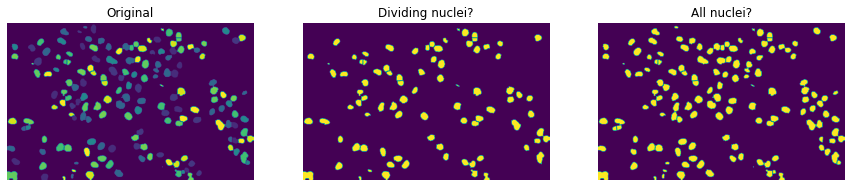

In [78]:
sc_thresh = filters.threshold_multiotsu(new_img_seg, classes=3)

cells = new_img_seg > sc_thresh[0]
dividing_grey = new_img_seg > sc_thresh[1]

print(sc_thresh[1])

fig1, ax1 = plt.subplots(ncols=3, figsize=(15, 5))
ax1[0].imshow(new_img_seg)
ax1[0].set_title('Original')
ax1[0].axis('off')
ax1[2].imshow(cells)
ax1[2].set_title('All nuclei?')
ax1[2].axis('off')
ax1[1].imshow(dividing_grey)
ax1[1].set_title('Dividing nuclei?')
ax1[1].axis('off')
plt.show()